In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8471026c-c267-28ec-a594-dc984b3c20ae)
GPU 1: Tesla T4 (UUID: GPU-a0732b8d-67ce-0351-6edd-75beb955fcca)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
from PIL import Image
import re
import matplotlib.patches as patches
!pip install ultralytics -qq
from ultralytics import YOLO
import os
import yaml

In [3]:
train = pd.read_csv("/kaggle/input/indabax-2024/Train.csv")
test = pd.read_csv("/kaggle/input/indabax-2024/Test.csv")

train.head()

,Image_ID,ToothClass,Xmin,Ymin,Xmax,Ymax
0,0,33,284,315,325,361
1,0,37,372,119,448,193
2,0,47,40,114,113,186
3,0,35,325,236,379,287
4,0,41,200,362,237,411


In [4]:
train.describe()

,Image_ID,ToothClass,Xmin,Ymin,Xmax,Ymax
count,16013.000000,16013.000000,16013.000000,16013.000000,16013.000000,16013.000000
mean,596.999688,28.997190,225.982702,262.817086,280.577094,318.527259
std,346.204113,11.360502,111.136081,88.792673,111.034216,80.025110
min,0.000000,11.000000,0.000000,0.000000,73.000000,66.000000
25%,297.000000,21.000000,119.000000,190.000000,170.000000,259.000000
50%,594.000000,31.000000,234.000000,282.000000,278.000000,332.000000
75%,897.000000,41.000000,336.000000,339.000000,388.000000,386.000000
max,1199.000000,48.000000,431.000000,431.000000,491.000000,491.000000


In [5]:
class_mapping = {
    11:0, 12:1, 13:2, 14:3, 15:4, 16:5, 17:6, 18:7,
    21:8, 22:9, 23:10, 24:11, 25:12, 26:13, 27:14, 28:15,
    31:16, 32:17, 33:18, 34:19, 35:20, 36:21, 37:22, 38:23,
    41:24, 42:25, 43:26, 44:27, 45:28, 46:29, 47:30, 48:31
}

# Map the 'ToothClass' column using the provided dictionary
train['ToothClass'] = train['ToothClass'].map(class_mapping)

In [6]:
unique_classes = train['ToothClass'].unique()
num_classes_unique = len(unique_classes)
num_classes_unique

32

In [7]:
directory_path = '/kaggle/input/indabax-2024/Train/train'
# List all filenames in the directory
filenames = os.listdir(directory_path)

# Create a DataFrame from the filenames
df = pd.DataFrame(filenames, columns=['ID'])

In [8]:
train['bbox'] = train.apply(lambda row: (row['Xmin'], row['Ymin'], row['Xmax'], row['Ymax']), axis=1)

In [9]:
unique_images = train['Image_ID'].unique()
len(unique_images)

1200

In [10]:
val_size = int(len(unique_images) * 0.2)
val_size

240

In [11]:
def transform_image_id(image_id):
    return f"ID_{image_id:06d}"

# Apply the transformation to the Image_ID column
train['Image_ID'] = train['Image_ID'].apply(transform_image_id)

In [12]:
train

,Image_ID,ToothClass,Xmin,Ymin,Xmax,Ymax,bbox
0,ID_000000,18,284,315,325,361,"(284, 315, 325, 361)"
1,ID_000000,22,372,119,448,193,"(372, 119, 448, 193)"
2,ID_000000,30,40,114,113,186,"(40, 114, 113, 186)"
3,ID_000000,20,325,236,379,287,"(325, 236, 379, 287)"
4,ID_000000,24,200,362,237,411,"(200, 362, 237, 411)"
...,...,...,...,...,...,...,...
16008,ID_001199,2,337,318,388,366,"(337, 318, 388, 366)"
16009,ID_001199,1,309,339,349,389,"(309, 339, 349, 389)"
16010,ID_001199,9,177,352,218,400,"(177, 352, 218, 400)"
16011,ID_001199,11,111,288,174,343,"(111, 288, 174, 343)"


In [13]:
unique_images = train['Image_ID'].unique()
train_imgs = unique_images[:(len(unique_images) - val_size)]
val_imgs = unique_images[-val_size:]

train_imgs.shape, val_imgs.shape

((960,), (240,))

In [14]:
train_idx = np.isin(train['Image_ID'].values, train_imgs)
val_idx = np.isin(train['Image_ID'].values, val_imgs)

train_idx.shape, val_idx.shape

((16013,), (16013,))

In [15]:
train_df = train.iloc[train_idx]
val_df = train.iloc[val_idx]

In [16]:
train_df.head()

,Image_ID,ToothClass,Xmin,Ymin,Xmax,Ymax,bbox
0,ID_000000,18,284,315,325,361,"(284, 315, 325, 361)"
1,ID_000000,22,372,119,448,193,"(372, 119, 448, 193)"
2,ID_000000,30,40,114,113,186,"(40, 114, 113, 186)"
3,ID_000000,20,325,236,379,287,"(325, 236, 379, 287)"
4,ID_000000,24,200,362,237,411,"(200, 362, 237, 411)"


In [17]:
a= len(train_df.ToothClass.unique())
train_df.ToothClass.unique()

array([18, 22, 30, 20, 24, 29, 27, 19, 28, 17, 16, 26, 25, 21, 31, 23, 13,  1, 10,  2,  6, 12,  5,  4,  9,  0,  3, 14,  8, 11, 15,  7])

In [18]:
sample_img = "ID_000001"

In [19]:
image_df = train_df[train_df['Image_ID'] == sample_img]

In [20]:
def plot_image_with_bbox(image_path, bboxes):
    img = Image.open(image_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        
        rect = plt.Rectangle((xmin, ymin), width, height, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

    plt.axis('off')  # Turn off axis
    plt.show()

In [21]:
img_path = "/kaggle/input/indabax-2024/Train/train/ID_000001.png"

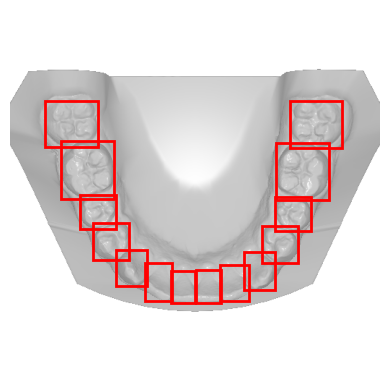

In [22]:
plot_image_with_bbox(img_path, image_df['bbox'].values)

In [23]:
#check for null values
for col in train_df:
    print(col, train_df[col].isnull().sum())

Image_ID 0
ToothClass 0
Xmin 0
Ymin 0
Xmax 0
Ymax 0
bbox 0


In [24]:
import shutil

In [25]:
copy_from_folder = "/kaggle/input/indabax-2024/Train/train"

In [26]:
def create_data_folder(destination_folder, df):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    unique_images = df['Image_ID'].unique()
    
    for img in unique_images:
        img_path = os.path.join(copy_from_folder, img + '.png')
        shutil.copy(img_path, destination_folder)

In [27]:
train_destination_folder = "/kaggle/working/train/images"
val_destination_folder = "/kaggle/working/val/images"

In [28]:
create_data_folder(train_destination_folder, train_df)
create_data_folder(val_destination_folder, val_df)

In [29]:
img = Image.open("/kaggle/input/indabax-2024/Train/train/ID_000001.png")
img.width, img.height

(512, 512)

In [30]:
img_width = 512
img_height = 512

In [31]:
from tqdm import tqdm

In [32]:
def decode_points(bbox):
    return bbox

In [33]:
def convert_bbox_to_string(bbox):
    box = decode_points(bbox)
    w = box[2] - box[0]  # width
    h = box[3] - box[1]  # height
    xc = box[0] + int(np.round(w / 2))  # x center
    yc = box[1] + int(np.round(h / 2))  # y center
    box = [xc / img_width, yc / img_height, w / img_width, h / img_height]
    box = [f"{i:.4g}" for i in box]
    return " ".join(box)

In [34]:
def create_label_folder(label_dir, dataframe):
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        
    unique_images = dataframe['Image_ID'].unique()
    
    for i,img in zip(tqdm(range(len(unique_images))), unique_images):
        df = dataframe[dataframe['Image_ID'] == img]
        output_lines = []
        for index, row in df.iterrows():
            category_id = int(row['ToothClass']) 

            bbox_string = convert_bbox_to_string(row['bbox'])
            output_lines.append(f'{category_id} {bbox_string}')

        with open(f"{label_dir}/{img}.txt", 'w') as f:
            for line in output_lines:
                f.write(line + '\n')

In [35]:
create_label_folder("/kaggle/working/train/labels", train_df)
create_label_folder("/kaggle/working/val/labels", val_df)

100%|██████████| 240/240 [00:00<00:00, 338.83it/s]


In [36]:
num_classes = 32
names = list(range(32))

In [37]:
train_dest_dir = "/kaggle/working/train"
val_dest_dir = "/kaggle/working/val"

In [38]:
dict_file = {
    'train': train_dest_dir,
    'val' : val_dest_dir,
    'nc': num_classes,
    'names': names
    }

with open("/kaggle/working/data.yaml", 'w+') as file:
    yaml.dump(dict_file, file)

In [39]:
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

yaml_data = read_yaml_file("/kaggle/working/data.yaml")

if yaml_data:
    print_yaml_data(yaml_data)

names:
- 0
- 1
- 2
- 3
- 4
- 5
- 6
- 7
- 8
- 9
- 10
- 11
- 12
- 13
- 14
- 15
- 16
- 17
- 18
- 19
- 20
- 21
- 22
- 23
- 24
- 25
- 26
- 27
- 28
- 29
- 30
- 31
nc: 32
train: /kaggle/working/train
val: /kaggle/working/val



In [40]:
#configure weights and biases
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [41]:
from ultralytics import YOLO

model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 241MB/s]  


In [66]:
EPOCHS = 100
BATCH_SIZE = 16
OPTIMIZER = "auto"
SEED = 88
NAME = f"Arm_Yolo_{EPOCHS}"
DEVICE = [0]
VERBOSE = False
RESUME = False
PATIENCE = 0

In [ ]:
%%time
### train
model.train(
    data = "/kaggle/working/data.yaml",
    augment=True,
    task = 'detect',
    imgsz = (img_height, img_width),
    epochs = EPOCHS,
    batch = BATCH_SIZE,
    optimizer = OPTIMIZER,
    patience = PATIENCE,
    name = NAME,
    seed = SEED,
    val = True,
    resume = RESUME,
    device = DEVICE,
    verbose = VERBOSE
)

Ultralytics YOLOv8.2.18 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=(512, 512), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=Arm_Yolo_100, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

wandb: Currently logged in as: mohamed-yassine-ben-zekri (20_mars). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=512'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/working/train/labels.cache... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/detect/Arm_Yolo_100/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000278, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to runs/detect/Arm_Yolo_100
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.4G     0.6755      2.497      1.041        209        512: 100%|██████████| 60/60 [00:53<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240       3178      0.859      0.799      0.885       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.74G     0.4264     0.6224     0.8823        217        512: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240       3178      0.819      0.856        0.9      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.73G      0.389     0.5341     0.8576        216        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240       3178      0.674      0.818      0.786      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.99G     0.3823     0.4647      0.845        216        512: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.761      0.852      0.844      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.96G     0.3705     0.4344     0.8377        214        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240       3178      0.794      0.844      0.881       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.95G     0.3648     0.4226     0.8323        220        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178       0.62       0.81      0.772      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.95G     0.3595     0.3757     0.8275        221        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.817      0.876      0.894      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.97G     0.3557     0.3606      0.826        205        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.816      0.871      0.891      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.95G     0.3519     0.3489     0.8248        212        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240       3178      0.739       0.86       0.87      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.95G     0.3514     0.3539     0.8265        218        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        240       3178      0.843       0.81      0.879      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.97G     0.3456     0.3476     0.8208        210        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.816      0.854      0.895      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.96G     0.3436       0.33     0.8225        217        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.891      0.904      0.923      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.96G     0.3472     0.3328     0.8212        217        512: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.852      0.868      0.903      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.95G     0.3418     0.3047     0.8209        209        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240       3178      0.874      0.894      0.906      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.93G     0.3383     0.2998      0.822        222        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.834      0.904      0.902      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.95G     0.3392      0.312     0.8205        212        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.895       0.91      0.933        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.95G     0.3392     0.3041     0.8154        203        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.804       0.86      0.891      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.95G     0.3397     0.2983     0.8169        212        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240       3178      0.834      0.868      0.887      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.96G     0.3377     0.2874     0.8187        222        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.892      0.934      0.922      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.95G     0.3334     0.2681     0.8167        212        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.855      0.879      0.919      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.95G     0.3383     0.2739     0.8148        216        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.869      0.904      0.919      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.93G     0.3327     0.2647     0.8151        213        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        240       3178      0.811      0.901      0.879      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.95G     0.3316     0.2628     0.8133        215        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.788      0.871      0.883       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.95G     0.3302     0.2572      0.813        217        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178       0.82      0.826      0.873      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.95G     0.3311     0.2413      0.813        216        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240       3178      0.881      0.882      0.914      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.95G     0.3312     0.2472     0.8147        216        512: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 4/8 [00:02<00:02,  1.44it/s]

In [49]:
import os
import csv
from ultralytics import YOLO

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
input_path = "/kaggle/input/indabax-2024/test/test"
output_path = "results.csv"

image_files = [file for file in os.listdir(input_path) if file.endswith('.jpg') or file.endswith('.png')]

with open(output_path, mode='w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax'])

    for image_file in image_files:
        image_path = os.path.join(input_path, image_file)
        results = model(image_path)
        for result in results:
            c = 0
            for detection in result.boxes.xyxy:
                row = [image_file.split('.')[0], "class_" + classes[int(result.boxes.cls[c])], round(float(result.boxes.conf[c]),2), int(detection[1]), int(detection[0]), int(detection[3]), int(detection[2])]
                c += 1
                csv_writer.writerow(row)

print("Results saved to:", output_path)

Results saved to: results.csv


In [61]:
sub = pd.read_csv('/kaggle/working/results.csv')

In [52]:
sub

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_001443,class_29,0.96,155,78,232,150
1,ID_001443,class_28,0.96,225,101,275,154
2,ID_001443,class_27,0.96,274,108,323,155
3,ID_001443,class_16,0.96,323,233,365,271
4,ID_001443,class_17,0.96,318,267,362,313
...,...,...,...,...,...,...,...
9388,ID_001629,class_8,0.96,366,196,417,256
9389,ID_001629,class_6,0.95,126,381,198,452
9390,ID_001629,class_14,0.95,122,61,193,135
9391,ID_001629,class_2,0.95,332,326,388,379


In [62]:
class_mapping = {
    11:0, 12:1, 13:2, 14:3, 15:4, 16:5, 17:6, 18:7,
    21:8, 22:9, 23:10, 24:11, 25:12, 26:13, 27:14, 28:15,
    31:16, 32:17, 33:18, 34:19, 35:20, 36:21, 37:22, 38:23,
    41:24, 42:25, 43:26, 44:27, 45:28, 46:29, 47:30, 48:31
}

# Function to reverse the class mapping
def reverse_class_mapping(mapping):
    return {v: k for k, v in mapping.items()}

# Reversed class mapping
reversed_class_mapping = reverse_class_mapping(class_mapping)

# Function to decode class numbers
def decode_class(class_name):
    # Extract the number from the class name string
    class_number = int(class_name.split('_')[1])
    # Map the class number using the reversed class mapping
    return  f'class_{reversed_class_mapping[class_number]}'


In [63]:
sub['class'] = sub['class'].apply(decode_class)

In [64]:
sub.to_csv('SampleSubmission.csv',index = False)

In [65]:
sub.describe()

,confidence,ymin,xmin,ymax,xmax
count,9393.000000,9393.000000,9393.000000,9393.000000,9393.000000
mean,0.903192,260.084425,225.657830,315.602363,280.053870
std,0.128554,89.155316,111.497563,80.482980,111.417933
min,0.250000,0.000000,0.000000,48.000000,70.000000
25%,0.930000,187.000000,117.000000,255.000000,169.000000
50%,0.950000,279.000000,234.000000,328.000000,276.000000
75%,0.960000,338.000000,335.000000,384.000000,389.000000
max,0.990000,434.000000,436.000000,490.000000,506.000000
